In [3]:
import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd

import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import nbimporter
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv1D, Conv2D,Dense, Dropout, Input, Concatenate, MaxPooling1D, BatchNormalization
import tensorflow.keras

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd
import sklearn
import warnings
warnings.filterwarnings("ignore")
import nbimporter
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Conv1D,Dense, Dropout, Input
import tensorflow.keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import json
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
import matplotlib.pyplot as plt
# import shap


cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)

In [4]:
%run -i geoprocessing.py
rand_state=np.random.randint(50)

In [5]:
path_departments ='Geojson_files/contour-des-departements.geojson'
French_departments = gpd.read_file(path_departments)
regions_names,geometries,code_list=geojson_extract(French_departments,np.arange(len(French_departments)),'nom','geometry','code')
geojson_columns= {'Region Name': regions_names, 'Geometry':geometries,'code':code_list}
Regions=gpd.GeoDataFrame(geojson_columns)
regs_to_remove=['Paris','Haute-Corse','Corse-du-Sud']

Regions, reg_names, code_list = remove_regions(Regions,regs_to_remove)
reg_names = replace_substring(reg_names)

In [6]:
#ignore
nb_years_tot=23
data_matrix_load = np.loadtxt("data_matrix_departments_2000_2022_abs_scaled.txt")
print(data_matrix_load.shape)

data_features=['u10',  't2m',  'tp']
# data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']

Nb_examples = len(Regions) * nb_years_tot
data_matrix_init= data_matrix_load.reshape(
    data_matrix_load.shape[0], len(data_features),365 )

data_matrix_init= data_matrix_init.transpose(0, 2, 1)

(2139, 1095)


In [7]:
#ignore
data_matrix_load = np.loadtxt("data_matrix_departments_2000_2022_abs_unscaled.txt")
print(data_matrix_load.shape)
data_features=['u10', 't2m', 'tp']
Nb_examples = len(Regions) * nb_years_tot
data_matrix_unscaled= data_matrix_load.reshape(
    data_matrix_load.shape[0], len(data_features),365 )
data_matrix_unscaled=data_matrix_unscaled.reshape((data_matrix_load.shape[0],len(data_features),365))

data_matrix_unscaled = data_matrix_unscaled.transpose(0, 2, 1)


(2139, 1095)


In [8]:
def unscaler(scaled_value,data_features,data_feature_idx,regs_min,regs_max):
    
    for reg in reg_filt:

    # Define the initial range of the data
        min_original = reg_mins[reg*len(data_features)+data_feature_idx]  # Minimum value of the original range
        max_original = reg_maxs[reg*len(data_features)+data_feature_idx]  # Maximum value of the original range        
        
        unscaled_value = scaled_value * (max_original - min_original) + min_original

    return unscaled_value
def heatmap_analysis(heatmap,crit_value):
    
    over50_idx=np.where(heatmap.T>crit_value)[0]
    
    return over50_idx

def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def get_date(year, day_of_year):
    if is_leap_year(year):
        days_in_year = 366
    else:
        days_in_year = 365

    if day_of_year < 1 or day_of_year > days_in_year:
        raise ValueError("Invalid day of the year. Must be between 1 and 366 for a leap year or 365 for a non-leap year.")

    start_date = datetime(year, 1, 1)
    target_date = start_date + timedelta(days=day_of_year - 1)
    return target_date.day, target_date.month, target_date.year
def find_bands(array, critical_value,mode):
    bands = []
    band_sizes = []
    band_start = None
    band_end = None

    for i, value in enumerate(array):
        if mode=='sup':
            if value >=critical_value :
                if band_start is None:
                    band_start = i
                    band_end = i
                else:
                    band_end = i
            else:
                if band_start is not None:
                    band_size = band_end - band_start + 1
                    bands.append((band_start, band_end))
                    band_sizes.append(band_size)
                    band_start = None
                    band_end = None
        if mode=='inf':
            if value <= critical_value :
                if band_start is None:
                    band_start = i
                    band_end = i
                else:
                    band_end = i
            else:
                if band_start is not None:
                    band_size = band_end - band_start + 1
                    bands.append((band_start, band_end))
                    band_sizes.append(band_size)
                    band_start = None
                    band_end = None

    if band_start is not None:
        band_size = band_end - band_start + 1
        bands.append((band_start, band_end))
        band_sizes.append(band_size)

    return band_sizes, bands
def modify_array(arr, delete_from_sides=True):
    if delete_from_sides:
        third = len(arr) // 3
        return arr[third:-third]
    else:
        third = len(arr) // 3
        middle_start = third
        middle_end = len(arr) - third
        return arr[middle_start:middle_end] 
    
def good_bad_day(ON,OFF,test_data,scale_left,scale_right,ratio_grads,interval):
    
    max_vars=[]
    min_vars=[]
    ON=ON[interval]
    OFF=OFF[interval]
    for var in range(len(test_data.T)):
                     
        max_on=max(np.asarray(ON[:,var]))
        min_on=min(np.asarray(ON[:,var]))
        
        max_vars.append(max_on)
        min_vars.append(min_on)
        
    good_days=0
    bad_days=0
    for var in range(len(test_data.T)):
                     
        for data_point in test_data:
            
            if min_vars[var]*scale_left <data_point[var] <max_vars[var]*scale_right :
                good_days+=ratio_grads[var]*(1/len(test_data.T))
                                             
            else:
                                             
                bad_days+=ratio_grads[var]*(1/len(test_data.T))
                                            
    return good_days,bad_days
                                            

def model_imp_interval(accept_percent,cultures_times):
    
    # Define the desired x% value
    desired_x_percent = accept_percent  # For example, 70%

    # Step 1: Sort the array
    sorted_data = np.sort(np.hstack(culture_times_off))

    # Step 2: Calculate the index range for the desired x%
    total_elements = len(sorted_data)
    start_index = int((100 - desired_x_percent) / 2 * total_elements / 100)
    end_index = int((100 + desired_x_percent) / 2 * total_elements / 100)

    # Step 3: Retrieve the values within the calculated index range
    interval = sorted_data[start_index:end_index]

    return np.arange(min(interval),max(interval),1)
def get_column_max_values(excel):
    try:
        # Read the Excel file
        df =excel
        max_values = []
        
        # Loop through columns (excluding the first column)
        for col_index in range(1, df.shape[1]):
            max_value = df.iloc[1:, col_index].max()  # Skip the first row
            max_values.append(max_value)
        
        return max_values
    except Exception as e:
        print("An error occurred:", e)
        return None

def gen_olymp(years_data, rendement, regions):
    val_olymp_abs = np.zeros((len(years_data) - 5, len(regions)))

    for year_ in range(len(years_data) - 5):
        year = years_data[year_ + 5]
        prod_region = np.asarray(rendement)
        
        for reg in range(len(regions)):
            val_olymp_year = []
            
            for i in range(5):
                iter_year = year - i
                val_olymp_year.append(
                    np.asarray(prod_region)[np.where(prod_region[:, 0] == iter_year)][0][reg + 1]
                )
            
            val_olymp_year.sort()  # Sort the values
            val_olymp_year = val_olymp_year[1:4]  # Remove min and max values
            
            val_olymp_abs[year_][reg] = np.mean(val_olymp_year)

    return val_olymp_abs

In [9]:
# Choix de la culture :

nb_experiments=1

culture_num=143


year_choice=2022
# [2021,2022]

test_score=False
data_test_size=0.1

#This will give us a score for test_size  if True

# Mettre False rendra les évaluations déterministes i.e même données d'entraînement, même données de test (utiles pour test de score avec d'autres paramètres), 
# Mettre True rendra les évaluations non déterministes

random = True

# [True,False]


feature_choice=[0,2,10]
data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']

# data_matrix_init=data_matrix_unscaled
# feature_choice=[0,1,2]
# data_features=['u10', 't2m', 'tp']



#Nombre d'itérations d'entraînement
nb_epochs=30
# [20 to 35]

#Départ de l'enregistrement de loss minimal trouvé
start_loss_checkpoint=10
# [8 to 15 ]


# Paramètres de l'optimiseur
optimizer_centering=False
#True,False
Verbose=0

# portions=np.arange(0.1,2.3,0.1)
# portion=np.round(np.mean(x_min_region),2)+0.1

In [10]:
import json
cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)
culture_name=cultures[str(culture_num)]
culture_name

'Tournesol'

In [11]:
#Données production, année début / année fin
year_start=2000
year_finish=2020

#Ensemble des années représentées en données de production
years_data=np.arange(year_start,year_finish+1,1)
#Lecture du fichier excel de production d'une culture

    
rendement = pd.read_excel('Production data/cultures_2000_2020/rendement/culture_'+str(culture_num)+'Rendement'+'.xlsx')


#Removing column name
reg_rep=np.delete(np.asarray(rendement.columns),0)

x_max_region,x_min_region,std_xmax,std_xmin,val_olymp_region,olymp_abs,mean_regions=gen_std_prod(years_data,rendement,reg_rep)

reg_filt = find_indices(code_list, reg_rep)


  
portions_min=np.round(np.mean(x_min_region),2)
portions_max=np.round(np.mean(x_max_region),2)
# portion=np.round(np.mean(x_min_region),2)
# portion=1.0
# portion=portions_max

portions=np.arange(portions_min,portions_max,0.01)
portion=portions_max
# portions=np.arange(portions_min,portions_max,0.05)

In [12]:
year_data_start=2000
drop_out_rate=0.1
outlayer_neurons=128

loss_histories=[]

year_pick=int(year_choice-year_data_start)
pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+len(years_data)*reg)

tf.keras.optimizers.RMSprop(
    learning_rate=0.0004,
    centered=optimizer_centering,
    use_ema=False,
    name="RMSprop",
)
f1=[]


if random == True:
    rand_state=np.random.randint(50)
portion=portions_max
#Construction et définition du réseau de neurones 
labels=gen_labels_portion_4(years_data,rendement,reg_rep,portion)
data_matrix=region_year_filter(reg_filt,years_data,nb_years_tot,data_matrix_init,24,[0,1,2])

# data_matrix=region_year_filter(reg_filt,years_data,nb_years_tot,data_matrix_init,24,feature_choice)

if year_pick<len(years_data):

    data_matrix=np.delete(data_matrix,pick_years,axis=0)
    labels=np.delete(labels,pick_years,axis=0)

nb_regions=len(Regions) 



model = Sequential([

      layers.Conv1D(365, 3, padding='same', activation='relu', input_shape=(365,len(feature_choice)),name='first_conv_layer'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(drop_out_rate),
      layers.Conv1D(128,2, padding='same', activation='relu',name='second_conv_layer'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(drop_out_rate),
      layers.Conv1D(64, 1, padding='same', activation='relu',name='last_conv_layer'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(drop_out_rate),
      layers.Flatten(),
      layers.Dense(outlayer_neurons, activation='relu',name='last_dense_layer'),
      layers.Dense(2,activation='softmax')

])



#Compilation du modèle
model.compile(optimizer='RMSProp',loss='CosineSimilarity',metrics='binary_accuracy' )

# x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.01,random_state=rand_state,shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.01,random_state=rand_state,shuffle=True)


mc = ModelCheckpoint('Test_weights/'+str(culture_num)+'_best_model_'+str(portion*100)+'.h5', monitor='val_loss', mode='min', verbose=0,save_best_only=True,start_from_epoch=start_loss_checkpoint)

history=model.fit(x_train, y_train,
                    epochs=nb_epochs,
                    batch_size=4,verbose=1,class_weight=weights(labels,'binary'),validation_split=0.25,callbacks=[mc])


Epoch 1/30
300/300 [==============================] - 8s 22ms/step - loss: -0.6400 - binary_accuracy: 0.8600 - val_loss: -0.8849 - val_binary_accuracy: 0.8850
Epoch 2/30
300/300 [==============================] - 6s 21ms/step - loss: -0.6678 - binary_accuracy: 0.6725 - val_loss: -0.8407 - val_binary_accuracy: 0.8850
Epoch 3/30
300/300 [==============================] - 6s 20ms/step - loss: -0.6760 - binary_accuracy: 0.8892 - val_loss: -0.8212 - val_binary_accuracy: 0.8675
Epoch 4/30
300/300 [==============================] - 6s 21ms/step - loss: -0.7003 - binary_accuracy: 0.7992 - val_loss: -0.7902 - val_binary_accuracy: 0.7375
Epoch 5/30
300/300 [==============================] - 6s 21ms/step - loss: -0.7120 - binary_accuracy: 0.8025 - val_loss: -0.7146 - val_binary_accuracy: 0.5750
Epoch 6/30
300/300 [==============================] - 6s 21ms/step - loss: -0.7152 - binary_accuracy: 0.8150 - val_loss: -0.8951 - val_binary_accuracy: 0.8825
Epoch 7/30
300/300 [==========================

In [13]:
from tensorflow.keras.models import load_model,Model

crit_score=555


feature_prod_map=np.zeros((len(reg_filt)*nb_years_tot,len(feature_choice)))
not_feature_prod_map=np.zeros((len(reg_filt)*nb_years_tot,len(feature_choice)))


grad_wind=[]
grad_total=[]
grad_temp=[]
grad_precip=[]
class_prob=[]

off_wind=[]
on_wind=[]
on_precip=[]
off_precip=[]
on_temp=[]
off_temp=[]


Summer = True
Winter=False # Change to False to delete the middle third

culture_times_on=[]
culture_times_off=[]
part_factor=0.9

years_tot=np.arange(2000,2023,1)
iter_=0
for year_choice in years_tot:
    # for i in range(len(reg_filt)):

    data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,[0,1,2])
    # data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)

    year_pick=int(year_choice-year_data_start)
    data_matrix3=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_unscaled,24,[0,1,2])
    
   

    pick_years=[year_pick]
    for reg in range(1,len(reg_filt)):
        pick_years.append(year_pick+nb_years_tot*reg)

    test_year_data=data_matrix2[pick_years]
    test_year_data2=data_matrix3[pick_years]
    # for ref
    for i in range(len(reg_filt)):
    # for year_choice in years_tot:

        idx_reg=reg_filt[i]

        # Prepare your test data and convert it to the required format
        test_data = test_year_data[i] # Replace with your actual test data
        test_data2 = test_year_data2[i]
        
        # Reshape the test data to match the model's input shape (if necessary)
        test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
        test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor

       
        
        # Get the Conv1D layer you want to target for visualization
        target_layer = model.get_layer('last_conv_layer')  # Replace with the correct layer name
        last_dense_layer = model.get_layer('last_dense_layer')
        # Create a new model that outputs the feature maps of the target layer
        feature_map_model = Model(inputs=model.input, outputs=target_layer.output)
        class_pred_model = Model(inputs=model.input, outputs=target_layer.output)
        sample_tensor = tf.convert_to_tensor(test_data)  # Convert the sample to a TensorFlow tensor
        if model.predict(sample_tensor)[:,1]>crit_score:
            continue
            
        # Calculate gradients of output with respect to model inputs
        target_class_index = 1  # Replace with the target class index you're interested in
        with tf.GradientTape() as tape:
            tape.watch(sample_tensor)
            predictions = model(sample_tensor)
            target_output = predictions[:, target_class_index]
        grads = tape.gradient(target_output, sample_tensor)
        feature_weights = np.mean(grads, axis=0)

        test_data_m=modify_array(test_data2[:,0],Summer)
        feature_weights_m=modify_array(feature_weights[:,0],Summer)
        off_wind.append(test_data_m[np.where(feature_weights_m<max(feature_weights_m)*part_factor)[0]])
        on_wind.append(test_data_m[np.where(feature_weights_m>max(feature_weights_m)*part_factor)[0]])
        
        test_data_m=modify_array(test_data2[:,2],Summer)
        feature_weights_m=modify_array(feature_weights[:,2],Summer)
        
        on_precip.append(test_data_m[np.where(feature_weights_m>max(feature_weights_m)*part_factor)[0]])
        off_precip.append(test_data_m[np.where(feature_weights_m<max(feature_weights_m)*part_factor)[0]])
        
        test_data_m=modify_array(test_data2[:,1],Summer)
        feature_weights_m=modify_array(feature_weights[:,1],Summer)
        
        on_temp.append(test_data_m[np.where(feature_weights_m>max(feature_weights_m)*part_factor)[0]])
        off_temp.append(test_data_m[np.where(feature_weights_m<max(feature_weights_m)*part_factor)[0]])
    
        
                        
        for feature in range(len(feature_choice)):
            
            # test_data_m=modify_array(test_data2[:,feature],Summer)
            # feature_weights_m=modify_array(feature_weights[:,feature],Summer)
            test_data_m=test_data2[:,feature]
            feature_weights_m=feature_weights[:,feature]

            
            
#             feature_prod_map[iter_][feature]=np.mean(test_data_m[np.where(feature_weights_m>np.std(feature_weights_m)*mul_factor)[0]])
#             not_feature_prod_map[iter_][feature]=np.mean(test_data_m[np.where(feature_weights_m<-np.std(feature_weights_m)*mul_factor)[0]])
            
            # feature_prod_map[iter_][feature]=np.mean(test_data_m[np.where(feature_weights_m>max(feature_weights_m)*part_factor)[0]])
            # not_feature_prod_map[iter_][feature]=np.mean(test_data_m[np.where(feature_weights_m<max(feature_weights_m)*part_factor)[0]])
            
            feature_prod_map[iter_][feature]=np.mean(test_data2[np.where(feature_weights[:,feature]>max(feature_weights[:,feature])*part_factor)[0]][:,feature])
            not_feature_prod_map[iter_][feature]=np.mean(test_data2[np.where(feature_weights[:,feature]<max(feature_weights[:,feature])*part_factor)[0]][:,feature])
            culture_times_on.append(np.where(feature_weights[:,feature]<max(feature_weights[:,feature])*part_factor)[0])
            culture_times_off.append(np.where(feature_weights[:,feature]>max(feature_weights[:,feature])*part_factor)[0])

              
        grad_wind.append(np.sum(feature_weights[:,0]))
        grad_temp.append(np.sum(feature_weights[:,1]))
        grad_precip.append(np.sum(feature_weights[:,2]))
        grad_total.append(np.sum(feature_weights[:,0])+np.sum(feature_weights[:,1])+np.sum(feature_weights[:,2]))

        class_prob.append(model.predict(sample_tensor)[:,0])
        iter_+=1

1/1 [==============================] - 0s 26ms/step


In [14]:
off_wind=np.hstack(off_wind)
on_wind=np.hstack(on_wind)
on_precip=np.hstack(on_precip)
off_precip=np.hstack(off_precip)
on_temp=np.hstack(on_temp)
off_temp=np.hstack(off_temp)

In [15]:
feature_prod_map2=np.delete(feature_prod_map,np.where(np.asarray(feature_prod_map)==float(0))[0],axis=0)
not_feature_prod_map2=np.delete(not_feature_prod_map,np.where(np.asarray(not_feature_prod_map)==float(0))[0],axis=0)

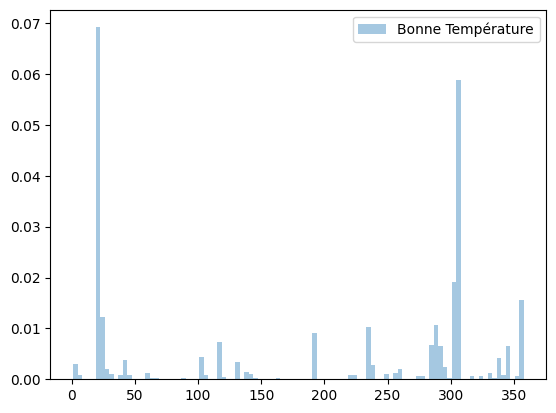

In [16]:
%matplotlib inline
# plt.hist(np.hstack(culture_times_on),bins=20,label='Mauvaise Température',alpha=0.3,density=True) 
plt.hist(np.hstack(culture_times_off),bins=100,label='Bonne Température',alpha=0.4,density=True) 
# plt.hist(np.asarray(feature_prod_map2)[:,1],bins=20,label='Bonnes Température',alpha=0.3,density=True) 
# plt.hist(np.asarray(not_feature_prod_map2)[:,1],bins=20,label='Mauvaise Température',alpha=0.4,density=True) 
# plt.distplot(np.hstack(culture_times_off),bins=20,label='Bonne Température',alpha=0.4,density=True)
# plt.legend()
plt.legend()

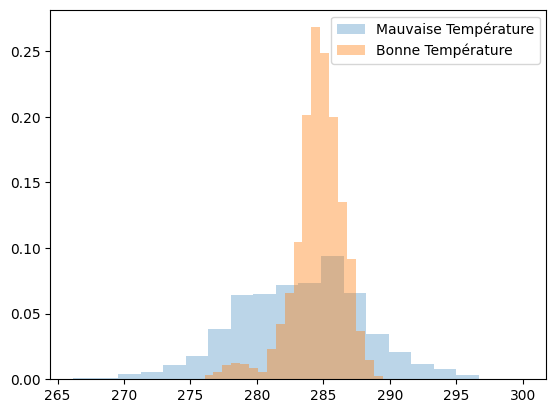

In [17]:
%matplotlib inline
plt.hist(np.asarray(feature_prod_map2)[:,1],bins=20,label='Mauvaise Température',alpha=0.3,density=True) 
plt.hist(np.asarray(not_feature_prod_map2)[:,1],bins=20,label='Bonne Température',alpha=0.4,density=True) 
# plt.hist(np.asarray(feature_prod_map2)[:,1],bins=20,label='Bonnes Température',alpha=0.3,density=True) 
# plt.hist(np.asarray(not_feature_prod_map2)[:,1],bins=20,label='Mauvaise Température',alpha=0.4,density=True) 

# plt.legend()
plt.legend()

In [18]:
max_on_temp=max(np.asarray(not_feature_prod_map2)[:,1])
max_off_temp=max(np.asarray(feature_prod_map2)[:,1])

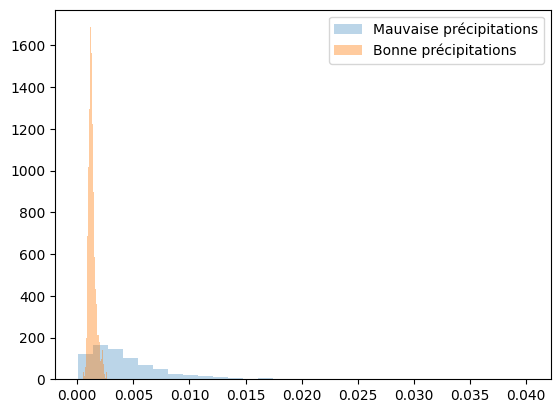

In [19]:
%matplotlib inline
# plt.hist(np.asarray(feature_prod_map2)[:,2],bins=30,label='Bonnes précipitations',alpha=0.3,density=True) 
# plt.hist(np.asarray(not_feature_prod_map2)[:,2],bins=30,label='Mauvaises précipitations',alpha=0.4,density=True) 
plt.hist(np.asarray(feature_prod_map2)[:,2],bins=30,label='Mauvaise précipitations',alpha=0.3,density=True) 
plt.hist(np.asarray(not_feature_prod_map2)[:,2],bins=30,label='Bonne précipitations',alpha=0.4,density=True) 
plt.legend()

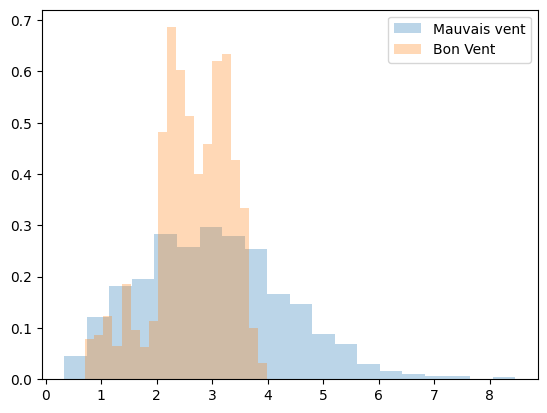

In [20]:
%matplotlib inline
plt.hist(np.asarray(feature_prod_map2)[:,0],bins=20,label='Mauvais vent',alpha=0.3,density=True) 
plt.hist(np.asarray(not_feature_prod_map2)[:,0],bins=20,label='Bon Vent',alpha=0.3,density=True) 
# plt.hist(np.asarray(feature_prod_map2)[:,0],bins=20,label='Bon vent',alpha=0.3,density=True) 
# plt.hist(np.asarray(not_feature_prod_map2)[:,0],bins=20,label='Mauvais Vent',alpha=0.3,density=True) 
# plt.legend()abs
plt.legend()

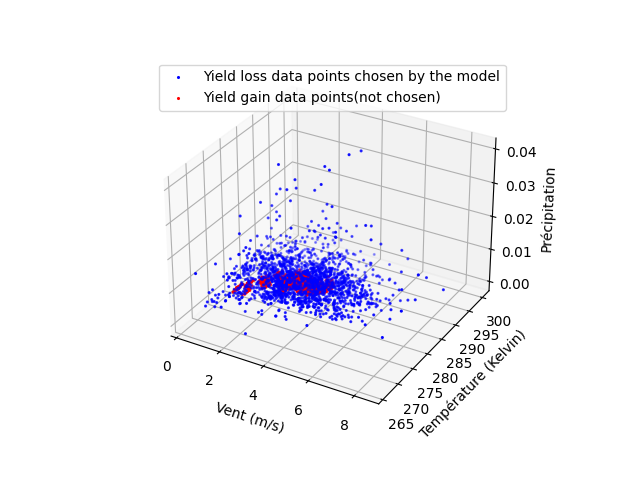

In [21]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter( np.asarray(feature_prod_map2)[:,0], np.asarray(feature_prod_map2)[:,1],np.asarray(feature_prod_map2)[:,2], c='b', marker='o', label='Yield loss data points chosen by the model',s=1.5)
ax.scatter( np.asarray(not_feature_prod_map2)[:,0], np.asarray(not_feature_prod_map2)[:,1],np.asarray(not_feature_prod_map2)[:,2], c='r', marker='o', label='Yield gain data points(not chosen) ',s=1.5)
# Plot the curves
# ax.plot(x, y, z, label='Curve 1', color='r')
# ax.plot(curve_x, curve_y2, curve_z, label='Curve 2', color='g')

# Set labels and legend
ax.set_xlabel('Vent (m/s)')
ax.set_ylabel('Température (Kelvin)')
ax.set_zlabel('Précipitation')
ax.legend()

# Show the plot
plt.show()

In [22]:
years_tot=np.arange(2000,2023,1)

year_choice=2016
idx_reg=reg_filt[i]
    # for i in range(len(reg_filt)):

data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,[0,1,2])
# data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)

year_pick=int(year_choice-year_data_start)
data_matrix3=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_unscaled,24,[0,1,2])



pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+nb_years_tot*reg)

test_year_data=data_matrix2[pick_years]
test_year_data2=data_matrix3[pick_years]

rendement_year=np.asarray(rendement)[np.where(rendement['Dept']==year_choice)[0]]
rendement_year=np.delete(rendement_year,0)



yield score example:  0.7331002331002386

Linear interpolation of yield from model:  21.99300699300716

Real yield value:  26.0
1/1 [==============================] - 0s 27ms/step
Probabilité classes : [[6.078512e-15 1.000000e+00]]
 
Number of good days:  209
Number of bad days:  155
Somme des gradients pour : u10 -4.041376e-14
Somme des gradients pour : t2m -8.5598236e-14
Somme des gradients pour : tp -4.5110777e-12
Somme totale des gradients pour :  -4.6370898e-12
 
Band Sizes: [1, 1, 1, 3, 1, 2, 2, 1, 1, 1, 2, 1, 4, 1, 4, 1, 2, 1, 2, 1, 2, 1, 2, 2]
Nombre de bandes pour la classe sup: 24
 Somme des bandes:  40
 
Band Sizes: [3, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 2, 1, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3]
Nombre de bandes pour la classe sup: 24
 Somme des bandes:  47


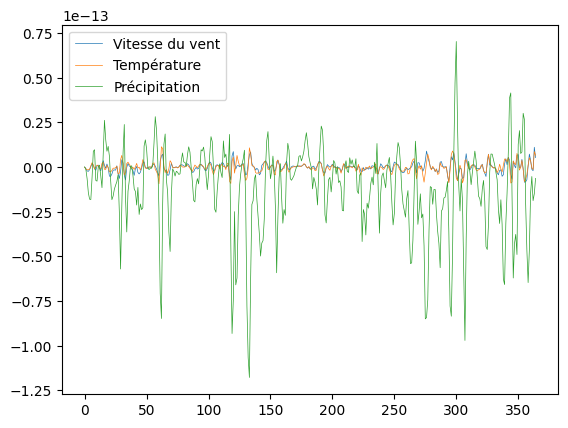

In [29]:
from tensorflow.keras.models import load_model,Model
%matplotlib inline
# Choose a sample from your dataset
sample_idx = 45
sample = test_year_data[sample_idx]
# Replace with your actual test data
sample2 = test_year_data2[sample_idx]

# ratio_grads=[1.3,0.4,1.3]      
ratio_grads=[1,1,1]
max_values = get_column_max_values(rendement)

historical_reg_max=max_values[sample_idx]

interval = model_imp_interval(70,culture_times_off)
good_days,bad_days=good_bad_day(not_feature_prod_map2,feature_prod_map2,sample2,1,1,ratio_grads,interval)

yield_score=float(good_days/len(interval))
print('yield score example: ',yield_score)
print('')
print('Linear interpolation of yield from model: ', yield_score*historical_reg_max)
print('')
print('Real yield value: ', rendement_year[sample_idx])
# print(model.predict(sample.T))
# Preprocess the sample to match the model's input shape and dtype
# You might need to adjust this based on your actual data preprocessing
sample = np.expand_dims(sample, axis=0)  # Add batch dimension if needed
sample = sample.astype(np.float32)  # Convert dtype to float32
# last_dense_layer = model.get_layer('last_dense_layer')
                                            


print('Probabilité classes :',model.predict(sample))
print(' ')
print('Number of good days: ',int(good_days))
print('Number of bad days: ',int(bad_days))
# Get te Conv1D layer you want to target for visualization
target_layer = model.get_layer('last_conv_layer')  # Replace with the correct layer name

# Create a new model that outputs the feature maps of the target layer
feature_map_model = Model(inputs=model.input, outputs=target_layer.output)
sample_tensor = tf.convert_to_tensor(sample)  # Convert the sample to a TensorFlow tensor

# Calculate gradients of output with respect to model inputs
target_class_index = 0  # Replace with the target class index you're interested in
with tf.GradientTape() as tape:
    tape.watch(sample_tensor)
    predictions = model(sample_tensor)
    target_output = predictions[:, target_class_index]
grads = tape.gradient(target_output, sample_tensor)
feature_weights = np.mean(grads, axis=0)

data = feature_weights[:,0]

print('Somme des gradients pour : ' + str(data_features[0]),np.sum(feature_weights[:,0]))
print('Somme des gradients pour : ' + str(data_features[2]),np.sum(feature_weights[:,1]))
print('Somme des gradients pour : ' + str(data_features[10]),np.sum(feature_weights[:,2]))
print('Somme totale des gradients pour : ' ,np.sum(feature_weights[:,0])+np.sum(feature_weights[:,1])+np.sum(feature_weights[:,2]))
print(' ')
# Example usage

crit = np.std(data)
band_sizes, bands = find_bands(data, crit, 'sup')
print("Band Sizes:", band_sizes)
print('Nombre de bandes pour la classe sup:',len(band_sizes))
print(' Somme des bandes: ',np.sum(band_sizes) )
print(' ')
# print("Bands (Start Index, End Index):", bands)
crit = -np.std(data)
band_sizes, bands = find_bands(data, crit, 'inf')
print("Band Sizes:", band_sizes)
print('Nombre de bandes pour la classe sup:',len(band_sizes))
print(' Somme des bandes: ',np.sum(band_sizes) )
# print("Bands (Start Index, End Index):", bands)
# Calculate feature weights for each feature within each time step

plt.plot(np.arange(len(feature_weights)),feature_weights[:,0],label='Vitesse du vent',linewidth=0.5) 
plt.plot(np.arange(len(feature_weights)),feature_weights[:,1],label='Température',linewidth=0.5) 
plt.plot(np.arange(len(feature_weights)),feature_weights[:,2],label='Précipitation',linewidth=0.5) 
plt.legend()


In [70]:
from tensorflow.keras.models import load_model,Model
%matplotlib inline
# Choose a sample from your dataset

# years_data=np.arange(2000,2021,1)
# olymp_vals=gen_olymp(years_data,rendement,reg_rep)

max_values = get_column_max_values(rendement)
years_data=np.arange(2000,2021,1)

year_iter=0
delta_rendement_linear_percent=[]
for year_choice in years_data:
    year_iter+=1
    idx_reg=reg_filt[i]
        # for i in range(len(reg_filt)):

    data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,[0,1,2])
    # data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)

    year_pick=int(year_choice-year_data_start)
    data_matrix3=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_unscaled,24,[0,1,2])



    pick_years=[year_pick]
    for reg in range(1,len(reg_filt)):
        pick_years.append(year_pick+nb_years_tot*reg)

    test_year_data=data_matrix2[pick_years]
    test_year_data2=data_matrix3[pick_years]

    rendement_year=np.asarray(rendement)[np.where(rendement['Dept']==year_choice)[0]]
    rendement_year=np.delete(rendement_year,0)
    
    delta_rendement_linear=[]

    
    for reg in range(len(test_year_data)):

        sample = test_year_data[reg]
        # Replace with your actual test data
        sample2 = test_year_data2[reg]

        ratio_grads=[1,1,1]      
        # ratio_grads=[1.3,0.6,1.4] 

        # historical_reg_max=max_values[reg]
        historical_reg_max=max(max_values)
        

        interval = model_imp_interval(50,culture_times_off)
        good_days,bad_days=good_bad_day(not_feature_prod_map2,feature_prod_map2,sample2,1,1,ratio_grads,interval)

        yield_score=float(good_days/len(interval))
        # print(yield_score)
        delta_rendement_linear.append(yield_score*historical_reg_max - rendement_year[reg])
        
        delta_rendement_linear_percent.append(((rendement_year[reg]-yield_score*historical_reg_max)/historical_reg_max)*100)



In [71]:
delta_main_min=np.mean(delta_rendement_linear_percent)-1*np.std(delta_rendement_linear_percent)
delta_main_max=np.mean(delta_rendement_linear_percent)+1*np.std(delta_rendement_linear_percent)

print('Trust interval (1 sigma) - 68% of values:')
print('Min: ',np.round(delta_main_min,2),'%')
print('Max: ',np.round(delta_main_max,2),'%')

delta_main_min=np.mean(delta_rendement_linear_percent)-2*np.std(delta_rendement_linear_percent)
delta_main_max=np.mean(delta_rendement_linear_percent)+2*np.std(delta_rendement_linear_percent)
print('Trust interval (2 sigma - 95% of values) :')
print('Min: ',np.round(delta_main_min,2),'%')
print('Max: ',np.round(delta_main_max,2),'%')

Trust interval (1 sigma) - 68% of values:
Min:  -15.47 %
Max:  11.95 %
Trust interval (2 sigma - 95% of values) :
Min:  -29.19 %
Max:  25.67 %


In [72]:
def percent_delta(x,delta_rendement_percent):
    under=np.where(np.hstack(delta_rendement_percent)<x )[0]
    over=np.where(np.hstack(delta_rendement_percent)>-x)[0]
    
    interval=np.intersect1d(under,over)
    percentage = len(interval)/len(delta_rendement_percent)
    return percentage*100


percent_delta_o=percent_delta(20,np.hstack(delta_rendement_linear_percent))
print(np.round(percent_delta_o,2),'%')

percent_delta_o=percent_delta(30,np.hstack(delta_rendement_linear_percent))
print(np.round(percent_delta_o,2),'%')

85.65 %
96.78 %


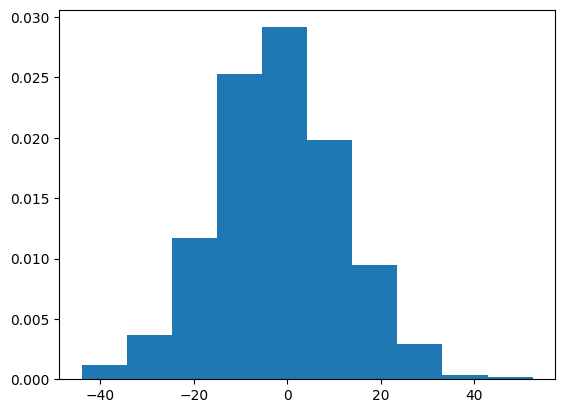

In [73]:
plt.hist(np.hstack(delta_rendement_linear_percent),density=True)
plt.show()